# Classify 250 Bird Species - Optimal Solu

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint, EarlyStopping
###
from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
###
from keras.optimizers import SGD, RMSprop, Adam, Adagrad
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dirs = os.listdir('/content/drive/My Drive/TPCN')
print(dirs)

Mounted at /content/drive
['dataset.zip']


In [ ]:
!unzip -q '/content/drive/My Drive/TPCN/dataset.zip'

In [ ]:
trainDirectory = os.listdir('dataset/train')
species = trainDirectory
trainLabels = species
print(trainLabels)

['OYSTER CATCHER', 'FLAMINGO', 'HOOPOES', 'IMPERIAL SHAQ', 'GUINEAFOWL', 'SUPERB STARLING', 'PELICAN', 'INDIAN BUSTARD', 'GRAY CATBIRD', 'RED HEADED WOODPECKER', 'GAMBELS QUAIL', 'JAVA SPARROW', 'SORA', 'RAZORBILL', 'WILSONS BIRD OF PARADISE', 'OKINAWA RAIL', 'SAND MARTIN', 'FLAME TANAGER', 'PURPLE MARTIN', 'SRI LANKA BLUE MAGPIE', 'EASTERN TOWEE', 'GRAY PARTRIDGE', 'AFRICAN CROWNED CRANE', 'RUFUOS MOTMOT', 'HOUSE SPARROW', 'CUBAN TODY', 'ANNAS HUMMINGBIRD', 'VENEZUELIAN TROUPIAL', 'NORTHERN MOCKINGBIRD', 'BAR-TAILED GODWIT', 'RED HONEY CREEPER', 'KILLDEAR', 'OSPREY', 'EURASIAN GOLDEN ORIOLE', 'ROSY FACED LOVEBIRD', 'INDIAN PITTA', 'ALEXANDRINE PARAKEET', 'CALIFORNIA CONDOR', 'WOOD DUCK', 'BLACK-NECKED GREBE', 'BARN SWALLOW', 'GREEN JAY', 'PUFFIN', 'CHUKAR PARTRIDGE', 'CROWNED PIGEON', 'CARMINE BEE-EATER', 'BANANAQUIT', 'BOBOLINK', 'BLACK SWAN', 'RAINBOW LORIKEET', 'COMMON STARLING', 'MALLARD DUCK', 'NICOBAR PIGEON', 'MALEO', 'LONG-EARED OWL', 'SNOWY OWL', 'ANTBIRD', 'D-ARNAUDS BARBET'

In [ ]:
nSpecies = len(np.unique(species))
print('Number of species for train:', nSpecies)

Number of species for train: 250


In [ ]:
testSpecies = os.listdir('dataset/test')
testLabels = testSpecies
print('Number of test species:',len(np.unique(testSpecies)))

valid = os.listdir('dataset/valid')
validationLabels = valid
print('Number of validation species:',len(np.unique(valid)))

Number of test species: 250
Number of validation species: 250


In [ ]:
datagen = ImageDataGenerator(rescale = 1./255, 
                             rotation_range = 0.2, shear_range = 0.5, 
                             horizontal_flip=True, vertical_flip=True)

In [ ]:
trainData = datagen.flow_from_directory('dataset/train', target_size = (224,224), class_mode='categorical')
steps = len(trainData)
testData  = datagen.flow_from_directory('dataset/test', target_size = (224,224), class_mode='categorical', shuffle = False)
validData = datagen.flow_from_directory('dataset/valid', target_size = (224,224), class_mode='categorical')
stepsValid = len(validData)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


# CNN with the best parameters found 

In [ ]:
def createModel():
    cl = 4
    cFilter = 256
    aFunc = 'relu' 
    drop = 0.3
    
    model = Sequential()
    
    # first convolution layer
    model.add(Conv2D(cFilter, kernel_size=(3,3), padding='valid', input_shape=(224,224,3), activation='relu'))
    model.add(BatchNormalization())

    # middle convolutional layers  
    for i in range(int(cl)):
        model.add(Conv2D(cFilter, kernel_size=(3,3), padding='valid', input_shape=(224,224,3), activation=aFunc))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
        model.add(Dropout(drop))
        
    # flattening
    model.add(Flatten())
    model.add(Dropout(drop))
    # full connection
    model.add(Dense(128,activation=aFunc))
    model.add(BatchNormalization())
    # dropout
    model.add(Dropout(drop))

     # output layer
    model.add(Dense(nSpecies,activation="softmax"))

    #compile model
    model.compile(RMSprop(learning_rate=0.001 ), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    model.summary()

    return model

CNNmodel = createModel()


es = EarlyStopping(monitor='val_loss', patience=5)

historyCNN = CNNmodel.fit(trainData, steps_per_epoch = steps,
                          epochs=50, verbose=1, 
                          validation_data = validData, validation_steps = stepsValid, 
                          callbacks = es)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 256)     7168      
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 256)     1024      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 256)     590080    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 256)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 110, 110, 256)     1024      
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 256)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 256)     5

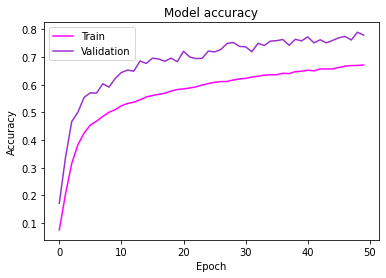

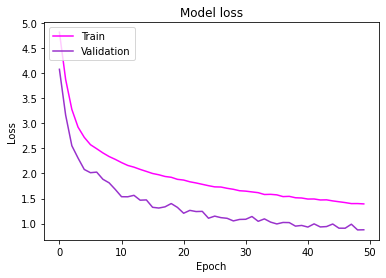

40/40 [==============================] - 15s 363ms/step - loss: 0.7927 - accuracy: 0.8072 - precision: 0.9325 - recall: 0.7072
Test loss: 0.7926665544509888
Test accuracy: 0.807200014591217
Test Precision: 0.9324894547462463
Test Recall: 0.7071999907493591


In [ ]:
#plot accuracy vs epoch
plt.plot(historyCNN.history['accuracy'], color='magenta')
plt.plot(historyCNN.history['val_accuracy'], color='darkorchid')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss values vs epoch
plt.plot(historyCNN.history['loss'], color='magenta')
plt.plot(historyCNN.history['val_loss'], color='darkorchid')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate against test data.
testCNN = CNNmodel.evaluate(testData, verbose=1)
print('Test loss:', testCNN[0])
print('Test accuracy:', testCNN[1])
print('Test Precision:', testCNN[2])
print('Test Recall:', testCNN[3])

In [ ]:
predictCNN = CNNmodel.predict(testData)

print(classification_report(testData.classes, tf.argmax(predictCNN, axis=-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       0.75      0.60      0.67         5
           3       1.00      0.80      0.89         5
           4       0.80      0.80      0.80         5
           5       0.80      0.80      0.80         5
           6       0.71      1.00      0.83         5
           7       1.00      1.00      1.00         5
           8       1.00      0.80      0.89         5
           9       0.50      0.80      0.62         5
          10       0.57      0.80      0.67         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      0.80      0.89         5
          14       1.00      1.00      1.00         5
          15       0.67      0.80      0.73         5
          16       0.83      1.00      0.91         5
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for i, prediction in enumerate(predictCNN):
    predicted_value = tf.argmax(prediction)
    label = predicted_value.numpy()
    print('Predicted a %d. Real value is %d.' %(predicted_value, testData.classes[i]))

Predicted a 0. Real value is 0.
Predicted a 0. Real value is 0.
Predicted a 0. Real value is 0.
Predicted a 0. Real value is 0.
Predicted a 0. Real value is 0.
Predicted a 1. Real value is 1.
Predicted a 1. Real value is 1.
Predicted a 1. Real value is 1.
Predicted a 1. Real value is 1.
Predicted a 1. Real value is 1.
Predicted a 146. Real value is 2.
Predicted a 2. Real value is 2.
Predicted a 2. Real value is 2.
Predicted a 146. Real value is 2.
Predicted a 2. Real value is 2.
Predicted a 196. Real value is 3.
Predicted a 3. Real value is 3.
Predicted a 3. Real value is 3.
Predicted a 3. Real value is 3.
Predicted a 3. Real value is 3.
Predicted a 4. Real value is 4.
Predicted a 155. Real value is 4.
Predicted a 4. Real value is 4.
Predicted a 4. Real value is 4.
Predicted a 4. Real value is 4.
Predicted a 38. Real value is 5.
Predicted a 5. Real value is 5.
Predicted a 5. Real value is 5.
Predicted a 5. Real value is 5.
Predicted a 5. Real value is 5.
Predicted a 6. Real value is 6.